In [1]:
import pickle as pkl
import numpy as np
import pandas as pd
import json
import sklearn
from sklearn import * 
from pytorch_v2 import TorchGame
from matplotlib import pyplot as plt
from matplotlib import cm
import torch
import numpy as np
import random, math

params_test = {
        "Horizon": 3, "Max_actions_chosen": 2, "N_actions_startpoint": 8, "I": .5, "D": 5,
        "Players_action_length": [5, 5], "Max_optim_iter": 75, "Filter_actions": True,
        "Stochastic_state_update": True, "base_params": "paper", "NumRepsBattle": 8,
        "DEVICE": "cpu", "MultiProcess": False
    }

game = TorchGame(**params_test) 
pkl_path = "saved_runs/Combitec_2023-05-01/History.pkl"
df = pd.read_pickle(pkl_path)
df = df.loc[:,:]

df.State[0] = game.flatten_var(torch.tensor(df.State[0].tolist())).numpy()



          PlayerA_y  PlayerB_y
sen_tec           4          4
col_sys           2          2
tec_mob           3          3
cont_alg          5          5
loc_map           3          3
sen_fus           3          3
ai_ml             2          2
edg_com           2          2
com_net           4          4
ene_mgm           4          4
sim_mod           2          2
hum_man           3          3
cyb_sec           3          3
eth_reg           2          2
          sen_tec  col_sys  tec_mob  cont_alg  loc_map  sen_fus  ai_ml   
A,B             0        0        0         0        0        0      0  \
Phi, Psi        9        3        1         3        3        9      3   
n_a,n_b         3        3        1         3        1        3      9   
p_a,p_b         9        1        1         3        9        3      1   
n_y,n_z         9        9        9         3        3        9      3   
p_y,p_z         9        3        3         3        3        3      9   
u,v             0

C:\Users\IsakG\AppData\Local\Temp\ipykernel_31936\1049729791.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.State[0] = game.flatten_var(torch.tensor(df.State[0].tolist())).numpy()


In [2]:
print(df.columns)
if (df["Reward"]==0).all():

    numReps = 100
    states = df["State"]
    states = [game.stack_var(torch.tensor(st)) for st in states.values.tolist()[0:]]
    thetas = [game.techToParams(st) for st in states]
    scores = [np.mean([game.SalvoBattleSequential(th).numpy() for _ in range(numReps)]) for th in thetas]
    scores = [None] + scores
    df["Reward"] = scores
    df.to_pickle(pkl_path)
# df["Reward"] = game.SalvoBattleSequential(game.techToParams()

Index(['Node_id', 'Parent_id', 'Time', 'State', 'Action', 'Reward'], dtype='object')


In [3]:
print(df.Action[1].shape,
    df.State[0].shape)

(28,) (28,)


In [4]:
# print(df.State[0])
# tmp = np.concatenate((df.State[0][:,0],df.State[0][:,1]),0)
# print(tmp)
# print(df.State[13])

# df.State[1] = tmp

In [5]:
plt.style.use('bmh')
plt.rcParams["figure.facecolor"] = "D1E2FF"
plt.rcParams["axes.facecolor"] = "F2F8FF"

# display(plt.rcParams.keys())

In [6]:
nParams, nTech = game.PARAMCONVERSIONMATRIX.size()
print(nParams, nTech)

8 14


In [7]:
def plot_trl(old_state, new_state, action):
    nParams, nTech = game.PARAMCONVERSIONMATRIX.size()
    print(nParams, nTech)
    

    old_state_A = old_state[:nTech]
    new_state_A = new_state[:nTech]
    
    old_trl_A = game.TechnologyReadiness(old_state_A).numpy()
    new_trl_A = game.TechnologyReadiness(new_state).numpy()

    
    old_state_B = old_state[nTech:]
    new_state_B = new_state[nTech:]
    
    old_trl_B = game.TechnologyReadiness(old_state_B).numpy()
    new_trl_B = game.TechnologyReadiness(new_state_B).numpy()
        
    state_grid = np.linspace(-1,12,1000)
    trl_base = game.TechnologyReadiness(torch.tensor(state_grid)).numpy()
    
    r, c = int(nTech/2), 2
    fig, axs = plt.subplots(r, c)
    fig.set_size_inches(16,28)
    for i in range(r):
        for j in range(c):
            k = 2*i + j
            # print(i,j,"-",k)
            # print(r,c)
            axs[i][j].plot(state_grid, trl_base)
            
            #old states
            axs[i][j].scatter(old_state_A[k].numpy(), old_trl_A[k], color="blue", alpha = .3)
            axs[i][j].scatter(old_state_B[k].numpy(), old_trl_B[k], color="red", alpha = .3)
            #new states
            axs[i][j].scatter(new_state_A[k].numpy(), new_trl_A[k], color="blue", alpha = 1)
            axs[i][j].scatter(new_state_B[k].numpy(), new_trl_B[k], color="red", alpha = 1)
            axs[i][j].set_title(game.TechnologyNames[k])
    fig.show()

def plot_act_theta(state, action):
    nParams, nTech = game.PARAMCONVERSIONMATRIX.size()
    
    action = game.stack_var(action)
    theta = game.techToParams(game.stack_var(state))
    
    theta_A = theta[:,0].numpy()
    action_A = action[:,0].numpy()
   
    theta_B = theta[:,1].numpy()
    action_B = action[:,1].numpy()
    
    fig, axs = plt.subplots(1,2)
    fig.set_size_inches(16,4)
    
    width = .5
    r = np.arange(nTech)
    axs[0].set_title("actions of each player")
    axs[0].bar(r, action_A, color="blue", width= width, label="Player1")
    axs[0].bar(r+width, action_B, color="red", width= width, label="Player2")
    # axs[1].xticks(r + width/2 , labels = game.ParamNames)
    axs[0].set_xticks(r + width/2)
    axs[0].set_xticklabels(labels = game.TechnologyNames)
    axs[0].legend()
    
    
    
    # width = .5
    r = np.arange(nParams)
    axs[1].set_title("battle Parameters of each player")
    axs[1].bar(r, theta_A, color="blue", width= width, label="Player1")
    axs[1].bar(r+width, theta_B, color="red", width= width, label="Player2")
    # axs[1].xticks(r + width/2 , labels = game.ParamNames)
    axs[1].set_xticks(r + width/2)
    axs[1].set_xticklabels(labels = game.ParamNames)
    axs[1].legend()



    # fig.show()
    fig.autofmt_xdate()
    
    
# df.Action[9]

In [8]:
# df[df.Node_id == 0].State.values

Index(['Node_id', 'Parent_id', 'Time', 'State', 'Action', 'Reward'], dtype='object')
4.0
8 14


C:\Users\IsakG\AppData\Local\Temp\ipykernel_31936\4204978552.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  old_state =  torch.tensor(df[df.Node_id == p_id].State.values.tolist()).squeeze()
C:\Users\IsakG\AppData\Local\Temp\ipykernel_31936\4288846605.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


tensor([ 4.5683,  2.2501,  3.3006,  5.6815,  3.0678,  3.1609, 16.0728,  2.3239,
         4.9855,  4.5866, 12.8350,  3.1182,  3.2694,  2.0782,  4.0555,  2.0027,
         3.1977,  5.5006,  3.1267,  3.0232,  3.1960,  2.0504,  4.0091,  4.0145,
         2.0143,  3.0043,  5.0481,  2.0002], dtype=torch.float64)
tensor([ 4.6477,  2.3291,  4.6181,  5.6867,  3.2801,  3.1644, 16.9201,  2.7733,
         5.4407,  4.7543, 25.2455,  3.6169,  3.4310,  2.1603,  4.0774,  2.0334,
         3.5557,  5.5056,  3.3451,  3.2658,  4.0975,  2.2154,  4.0166, 12.9790,
         2.0482,  3.0108,  5.0503,  2.0078], dtype=torch.float64)
tensor([1.1972e-03, 5.2161e-03, 2.6135e-01, 1.0547e-02, 1.1030e-02, 1.0194e-03,
        2.6756e+00, 8.4321e-02, 2.2882e-02, 8.6376e-02, 1.8035e+00, 1.0414e-02,
        2.2500e-02, 4.0216e-03, 2.4889e-04, 1.8159e-04, 2.7077e-03, 7.2511e-04,
        6.6095e-04, 3.8013e-05, 7.2818e-04, 1.0451e-03, 1.2665e-03, 4.9903e+00,
        2.2882e-04, 3.4896e-04, 1.2541e-03, 2.2694e-04])


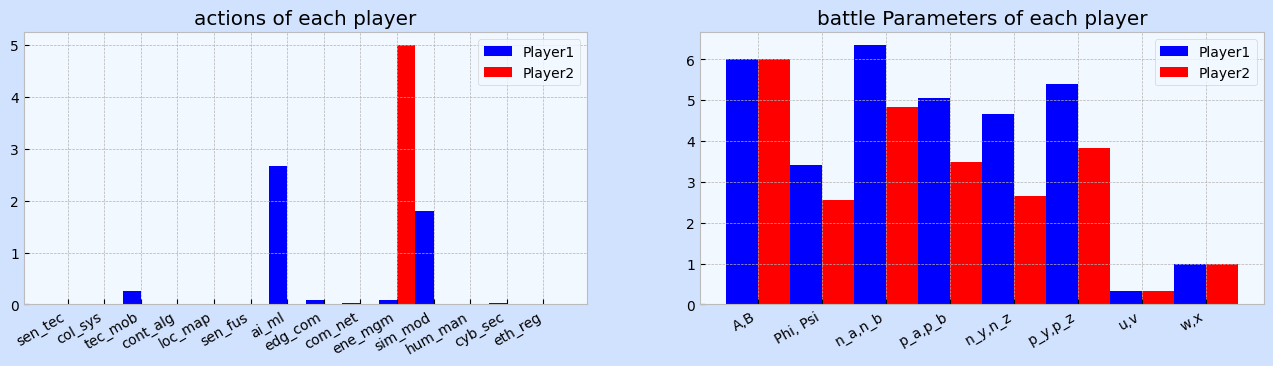

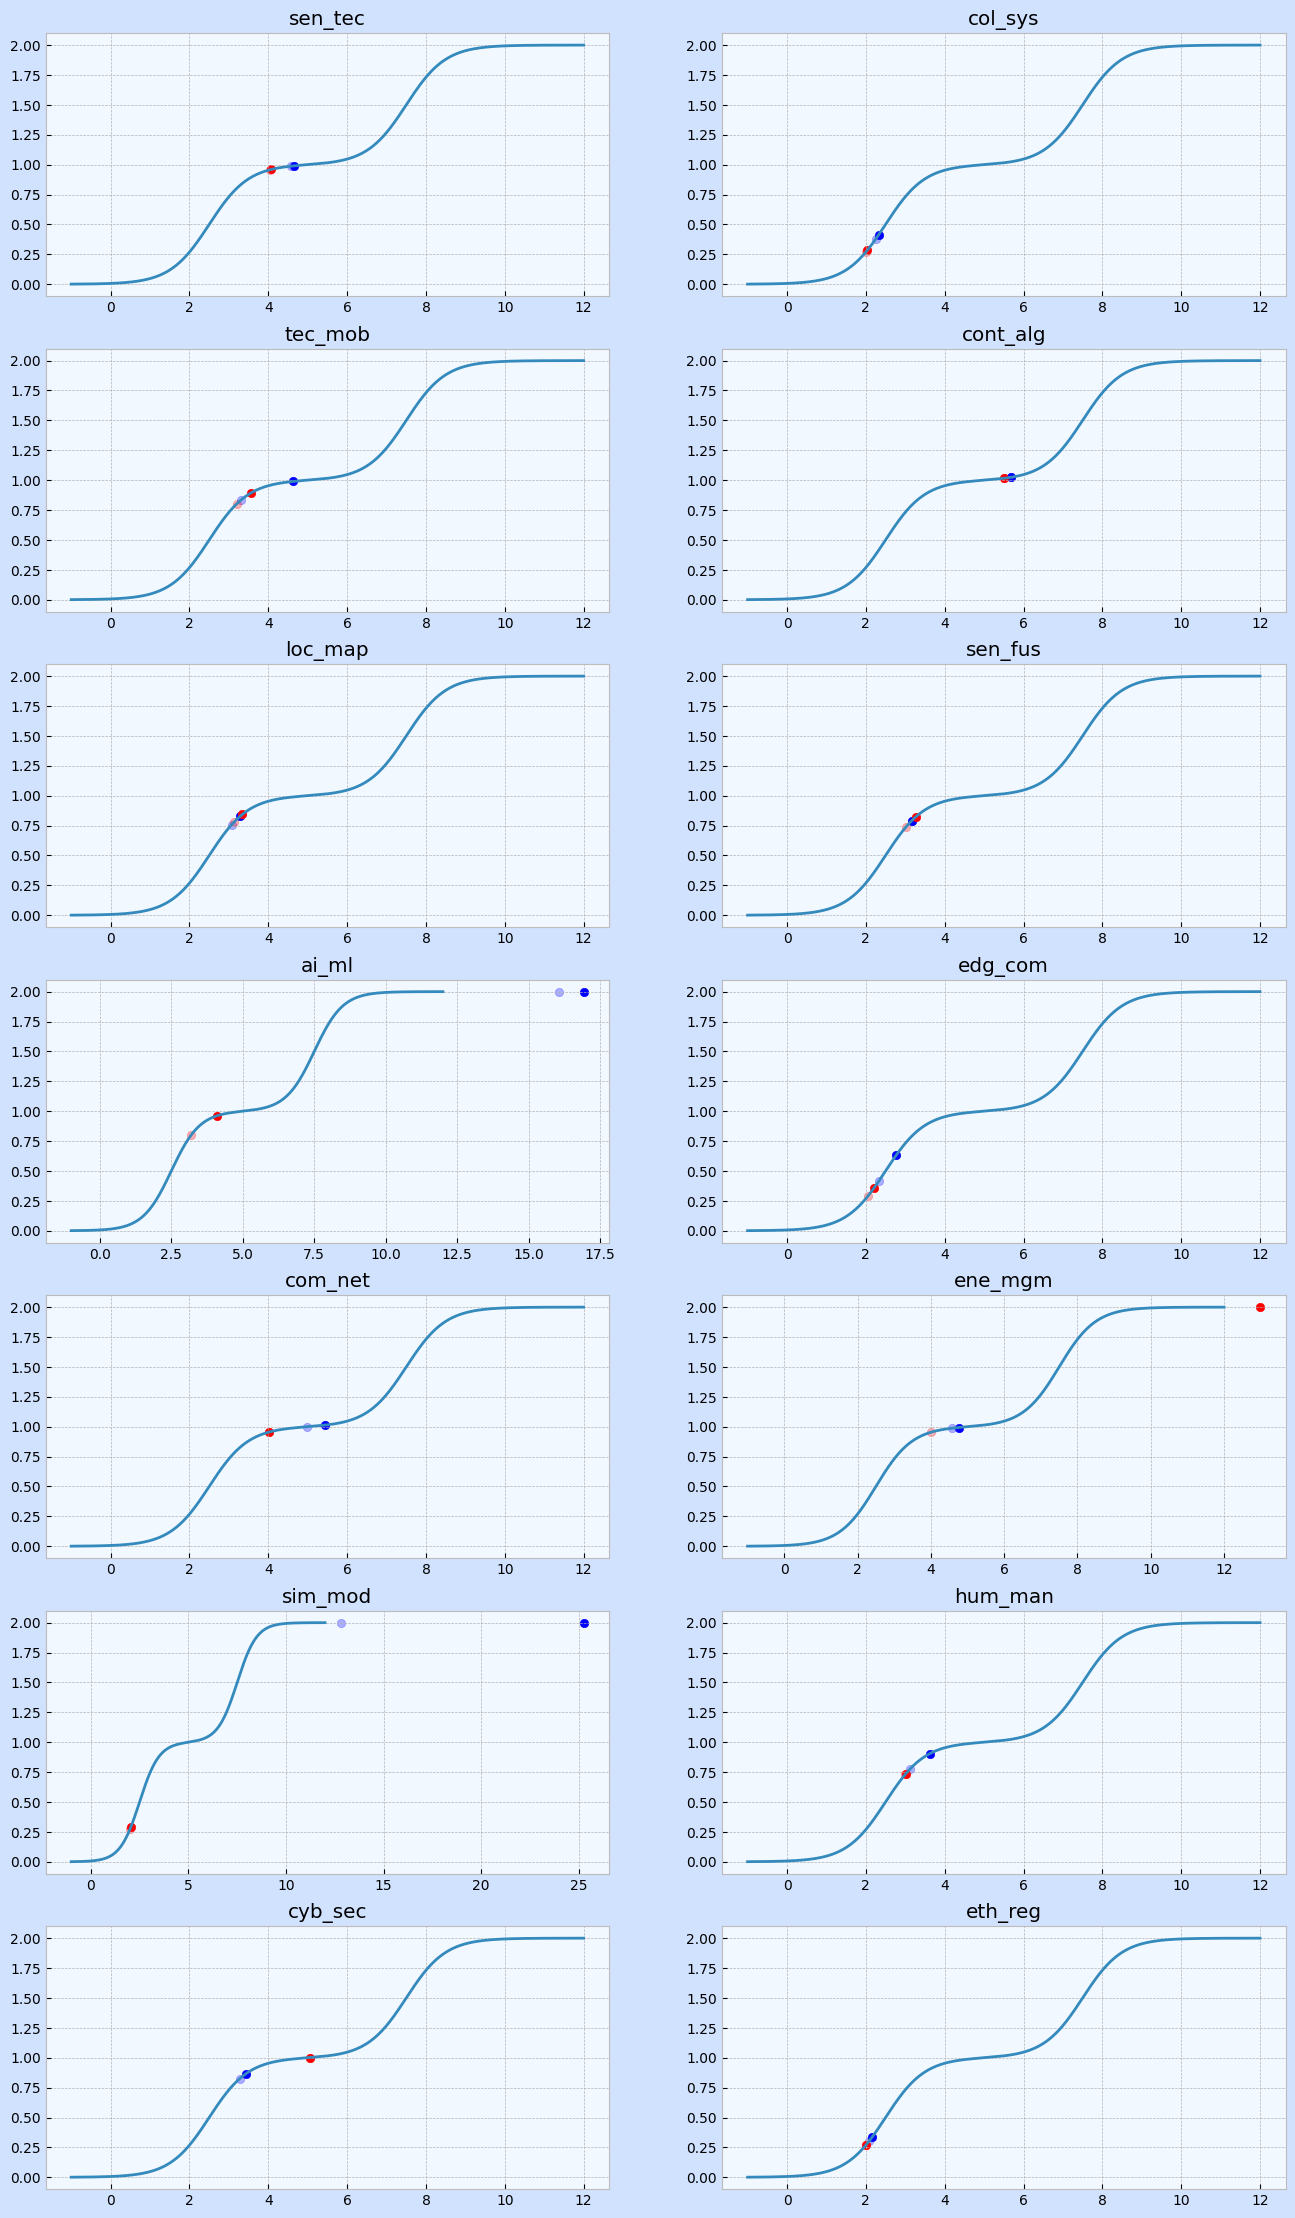

In [9]:

print(df.columns)
numPoints = len(df.index)
old_state_i = df.Parent_id
states =df.State
actions = df.Action

plot_ind = 5

p_id = df.loc[plot_ind,:].Parent_id
print(p_id)
old_state =  torch.tensor(df[df.Node_id == p_id].State.values.tolist()).squeeze()

new_state =  torch.tensor(states[plot_ind]).squeeze()

act = torch.tensor(actions[plot_ind]).squeeze()
plot_act_theta(new_state, act)
plot_trl(old_state,new_state, act)


print(old_state)
print(new_state)
print(act)

In [10]:
n = 10000
mu = torch.tensor([0.05]*n)
std = torch.tensor([1.5]*n)

dist = torch.distributions.log_normal.LogNormal(torch.tensor([0.05]*10), torch.tensor([1.5]*10), validate_args=None)
dist.rsample([1])
# draws_norm = torch.normal(mean=mu,std=std).exp()
# draws_lognorm = dist.rsample([n])

# plt.hist(draws_norm.numpy(), bins=100,density=True, color="red")

# plt.hist(draws_lognorm.numpy(), bins=100,density=True, color="blue")
# plt.show()

tensor([[0.3701, 0.2736, 0.6686, 4.8144, 1.6578, 0.0546, 0.8914, 0.2015, 1.0400,
         1.7285]])

In [11]:
# (.values.astype(np.float32))

acts = torch.tensor(df.Action.dropna().values.tolist())
# Vals.shape
# Vals[:,game.N_Technologies:]

In [12]:
getattr(df, "State").dropna().values.tolist()
# torch.tensor(getattr(df, "State").dropna().values.tolist())

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([ 4.49195352, 12.03330612,  4.31310701,  5.05503639,  3.04081086,
         3.00920485,  2.49399605,  2.86433291,  6.47453451,  4.21758051,
         2.37574935,  3.15451062,  3.43821272,  3.07302296,  4.00971554,
         2.00601985,  3.07501057,  5.04553215,  3.22719109,  3.01852771,
         2.10833445,  2.0212891 ,  4.31929022,  4.16487816, 32.92234993,
         3.01103775,  4.63246441,  2.00116285]),
 array([ 4.1105897 ,  2.93511188,  3.9970594 ,  5.10150074,  8.17080832,
         3.06722619,  2.53260589,  2.14598556,  4.39341578,  4.22856283,
        21.27757454,  4.08491075,  3.00823356,  2.04812443,  4.16697808,
         2.00889925,  3.013489  ,  5.3639794 ,  3.0033414 ,  3.08839171,
         2.07594861,  2.03398743,  4.47367018,  4.06910596,  2.2146208 ,
         3.01308004,  3.00318887,  2.02748664]),
 array([9.35646343, 2.00215

C:\Users\IsakG\AppData\Local\Temp\ipykernel_31936\4150749836.py:91: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\IsakG\AppData\Local\Temp\ipykernel_31936\4150749836.py:91: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\IsakG\AppData\Local\Temp\ipykernel_31936\4150749836.py:91: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\IsakG\AppData\Local\Temp\ipykernel_31936\4150749836.py:91: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\IsakG\AppData\Local\Temp\ipykernel_31936\4150749836.py:91: UserWarning: Matplotlib is currently using m

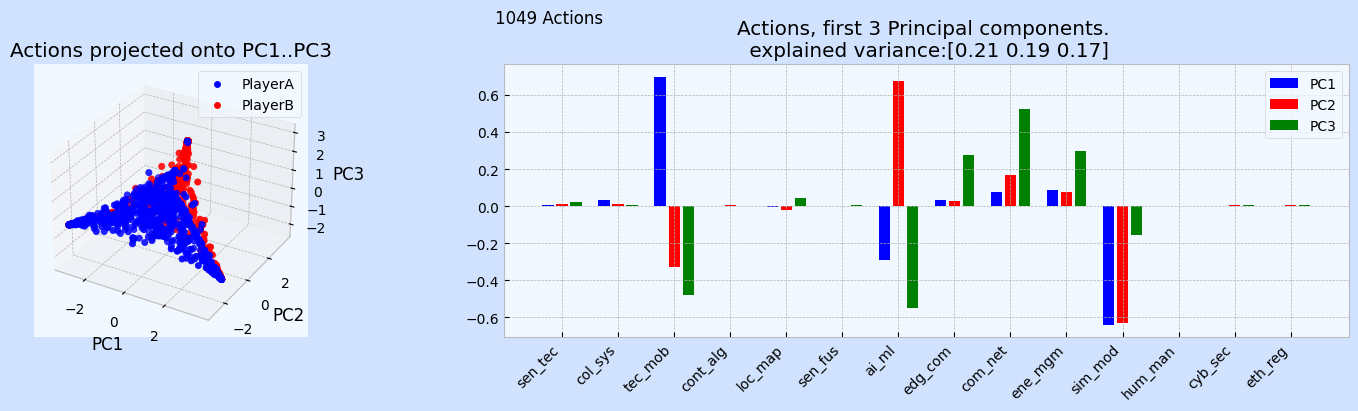

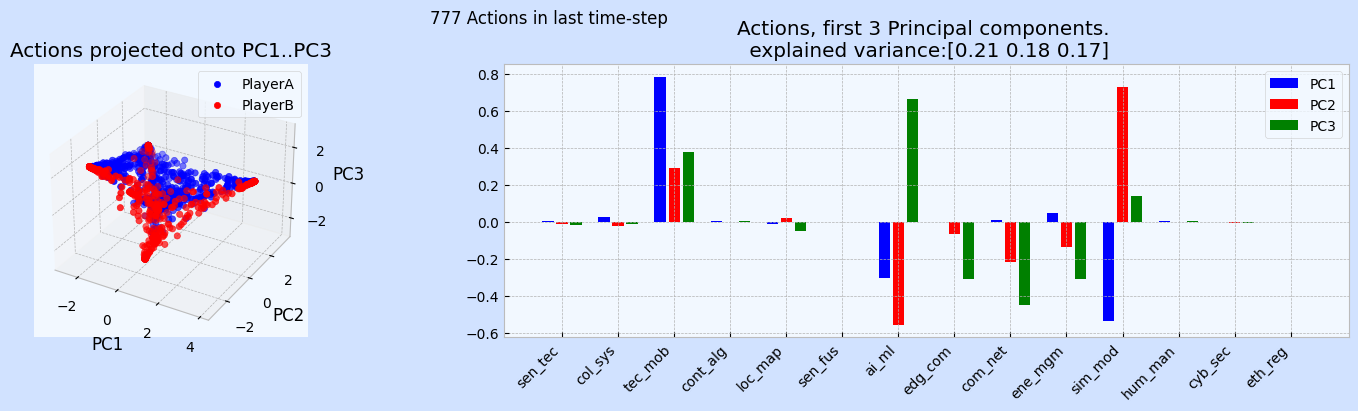

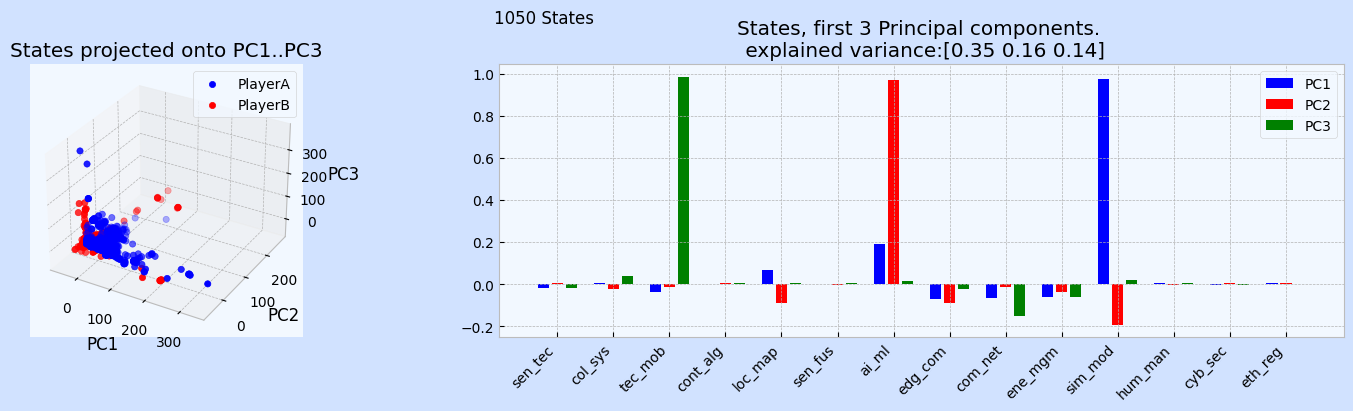

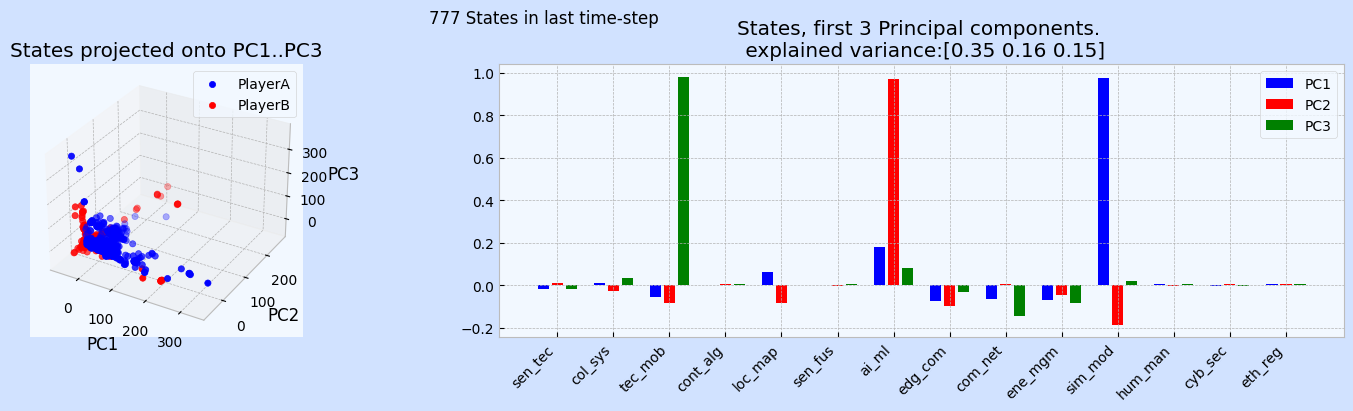

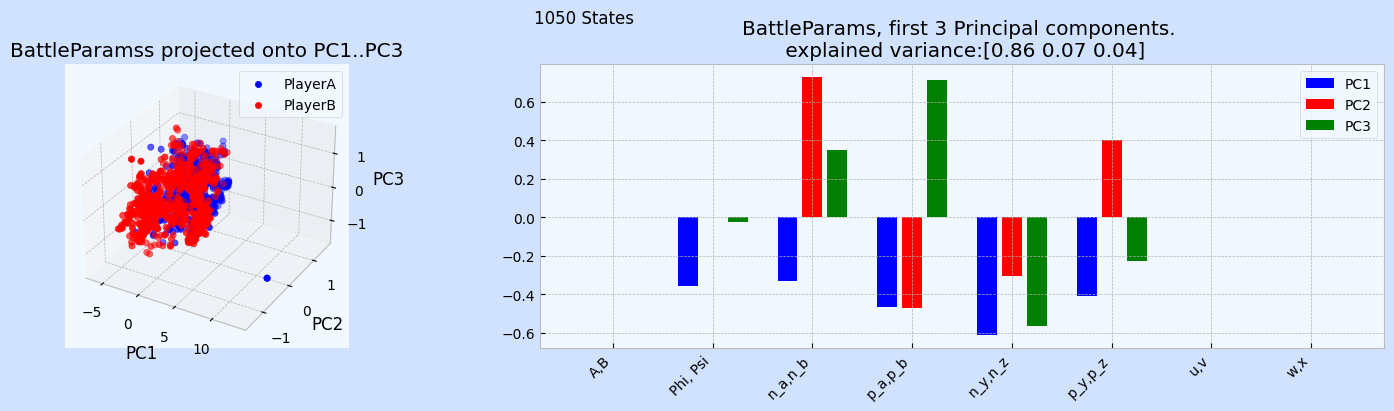

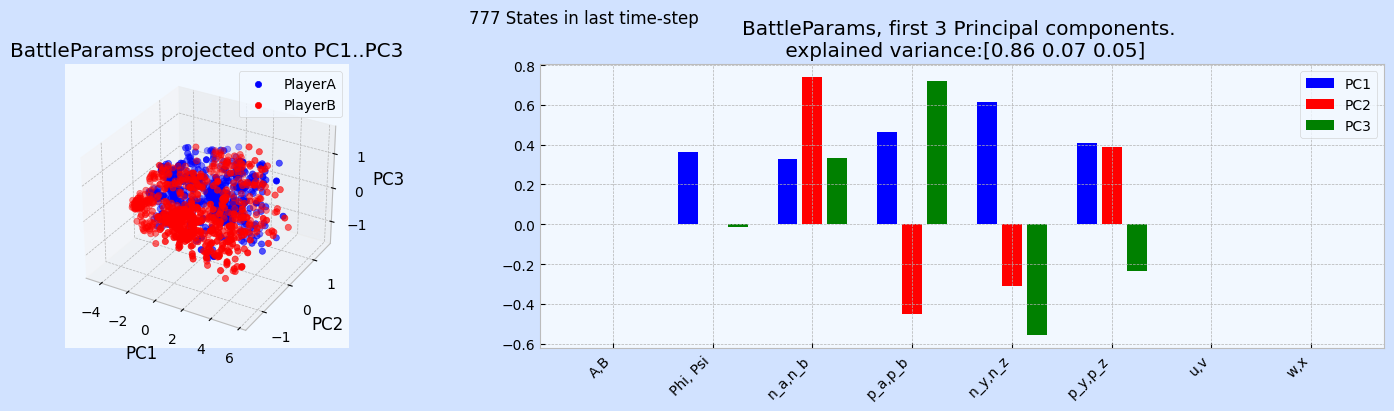

In [13]:
# num
def one_sided_pca_plot(df, key, t_max):
    
    if t_max:
        df = df[df.Time == df.Time.max()]
    if key == "Theta":
        key = "State"
        theta = True
    else: 
        theta = False
    
    
    
    vals = torch.tensor(getattr(df, key).dropna().values.tolist())
    numVals = vals.shape[0]
    if theta:
        thetas = []
        for i in range(numVals):
            # print(vals.shape)
            nTech = int(vals.shape[1] / 2)
            
            # a = vals[i,:nTech].T
            # b = vals[i,nTech:].T
            # print(a,b)
            state = game.stack_var(vals[i,:])
            # print(state)
            th = game.techToParams(state).numpy()
            thetas.append(th[:,0])            
            thetas.append(th[:,1])
            allVals = thetas
    else:
       
        valsA, valsB = (vals[:,:game.N_Technologies]).numpy(), (vals[:,game.N_Technologies:]).numpy()
        allVals = np.concatenate((valsA,valsB),0)
        
    
    pca = sklearn.decomposition.PCA(3)
    pca_fit_AB = pca.fit_transform(allVals)
    
    pca_fit_A = pca_fit_AB[:numVals,:]
    pca_fit_B = pca_fit_AB[numVals:,:]

    fig = plt.figure(figsize=(16,4))
    # fix , axs = plt.subplots(1,2,width_ratios=(1,3))
    # ax = axs[0]
    if t_max:
        fig.suptitle(f"{numVals} {key}s in last time-step")
    else:
        fig.suptitle(f"{numVals} {key}s")
        
    ax = fig.add_subplot(1,2, 1 ,projection='3d')

    ax.scatter(pca_fit_A[:,0], pca_fit_A[:,1], pca_fit_A[:,2], color="blue", label="PlayerA")
    ax.scatter(pca_fit_B[:,0], pca_fit_B[:,1], pca_fit_B[:,2], color="red", label="PlayerB")

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    
    ax.set_title(f"{key if  not theta else 'BattleParams'}s projected onto PC1..PC3")
    
    ax.legend()
    
    
    components = pca.components_
    var = pca.explained_variance_ratio_
    
    nTech = np.shape(components[0])[0]
    nComps = len(components)
   
    ax2 = fig.add_subplot(1,2,2 )
    ax2.set_title(f"{key if  not theta else 'BattleParam' }s, first {nComps} Principal components. \n explained variance:{np.round(var,2)}")
    
   
    width = .5
    r = np.arange(nTech)
    
    ax2.bar(r, components[0], color="blue", width=1/5, label="PC1")
    ax2.bar(r + width/2, components[1], color="red", width=1/5, label="PC2")
    ax2.bar(r + width, components[2], color="green", width=1/5, label="PC3")
    if  theta:
        ax2.set_xticks(r + width/2, game.ParamNames, rotation = 45, ha="right")
    else:
        ax2.set_xticks(r + width/2, game.TechnologyNames, rotation = 45, ha="right")
    # ax2.set_xticklabels(labels = game.TechnologyNames)
    # ax2.set_x
    ax2.legend()
    
    
    fig.tight_layout(h_pad = 0, pad=0)
    fig.show()
    

one_sided_pca_plot(df,"Action", False)
one_sided_pca_plot(df,"Action", True)
one_sided_pca_plot(df,"State", False)
one_sided_pca_plot(df,"State", True)
one_sided_pca_plot(df, "Theta", False)
one_sided_pca_plot(df, "Theta", True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\IsakG\AppData\Local\Temp\ipykernel_31936\3323980785.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\IsakG\AppData\Local\Temp\ipykernel_31936\3323980785.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\IsakG\AppData\Local\Temp\ipykernel_31936\3323980785.py:87: UserWarning: Matp

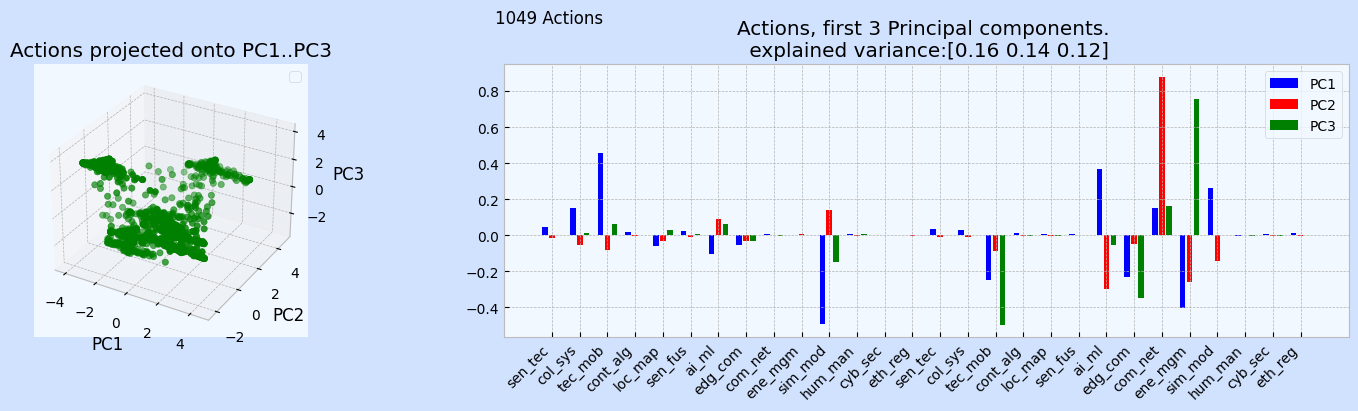

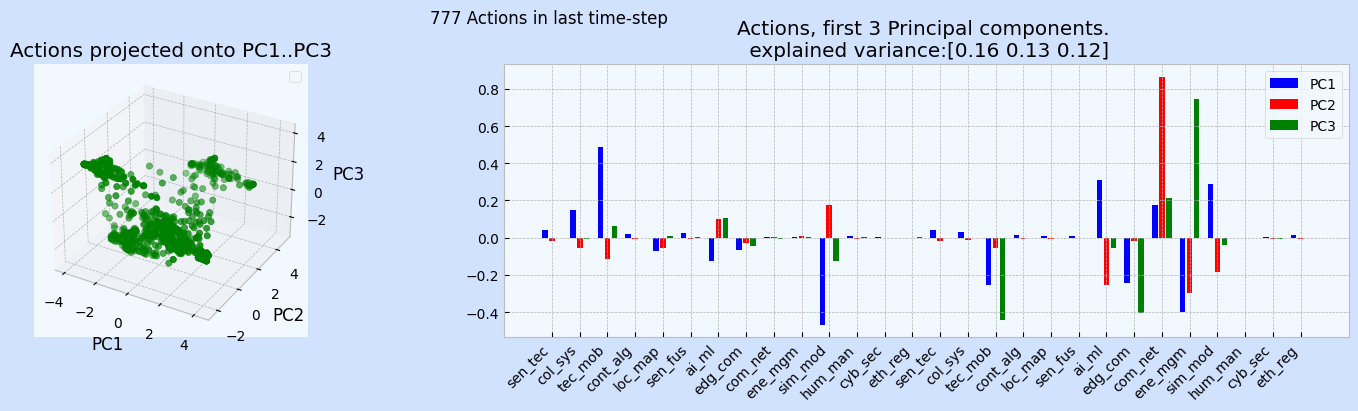

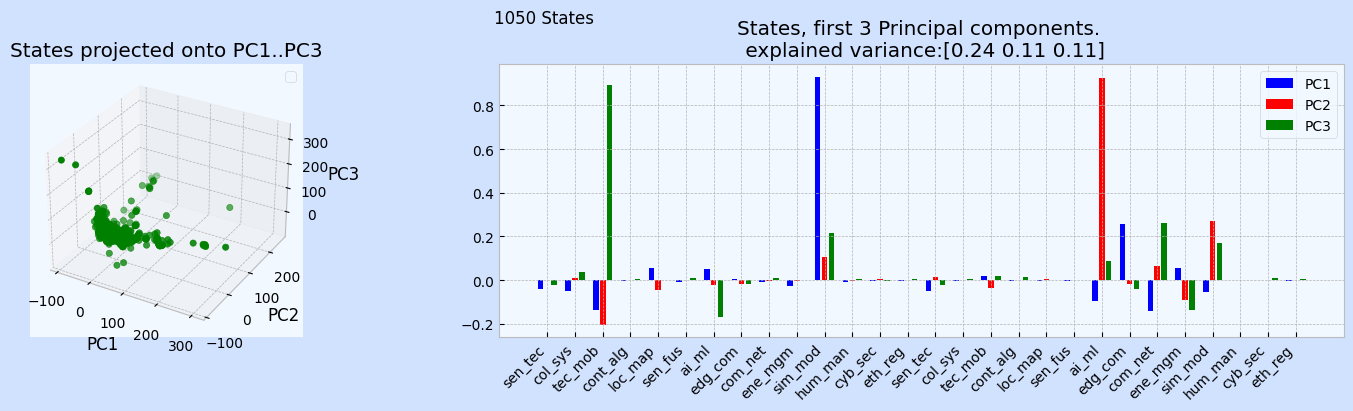

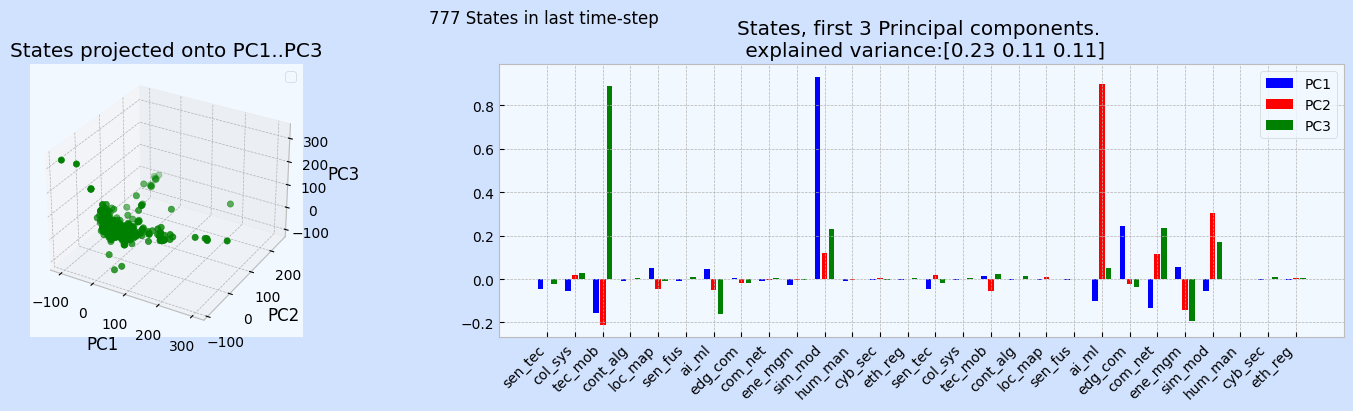

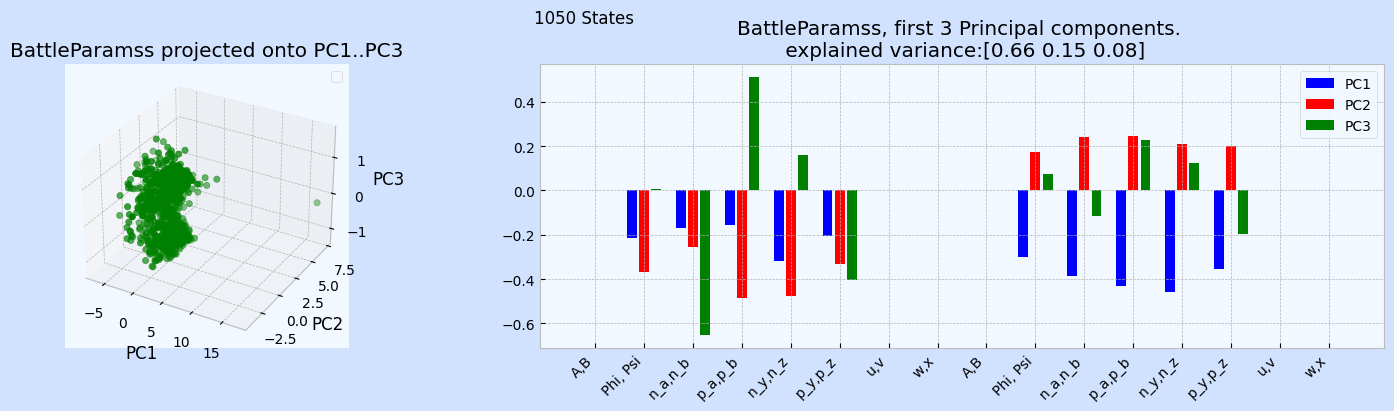

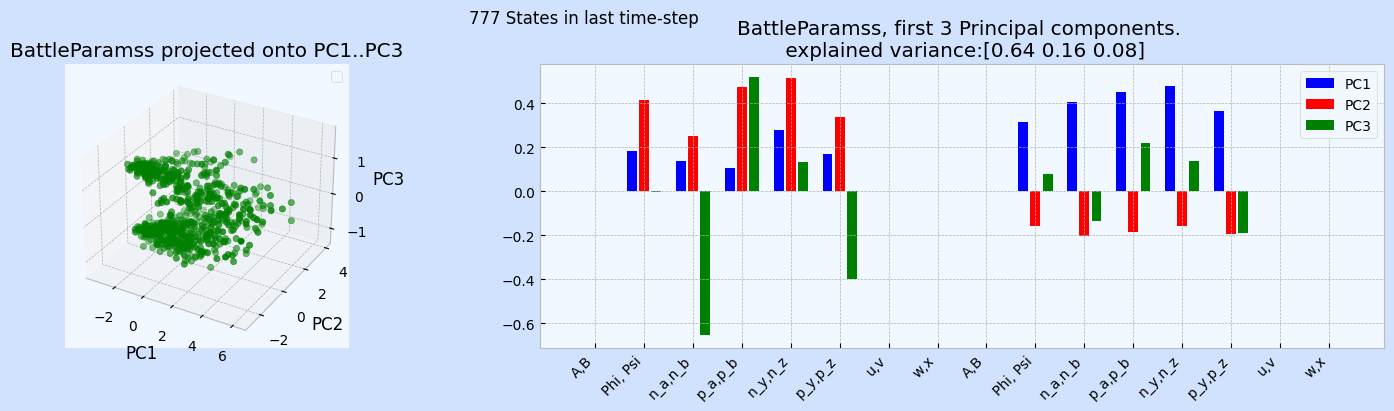

In [14]:
# num
def two_sided_pca_plot(df, key, t_max):
    if t_max:
        df = df[df.Time == df.Time.max()]
    if key == "Theta":
        key = "State"
        theta = True
    else: 
        theta = False
        
    vals = torch.tensor(getattr(df, key).dropna().values.tolist())
    numVals = vals.shape[0]
    if theta:
        thetas = []
        for i in range(numVals):
            # print(vals.shape)
            nTech = int(vals.shape[1] / 2)
            
            # a = vals[i,:nTech].T
            # b = vals[i,nTech:].T
            # print(a,b)
            state = game.stack_var(vals[i,:])
            # print(state)
            th = game.flatten_var(game.techToParams(state)).numpy()
            thetas.append(th)            
            # thetas.append(th)
            allVals = thetas
    else:

        valsA, valsB = (vals[:,:game.N_Technologies]).numpy(), (vals[:,game.N_Technologies:]).numpy()
        allVals = np.concatenate((valsA,valsB),1)
        
    
    pca = sklearn.decomposition.PCA(3)
    pca_fit = pca.fit_transform(allVals)
    
    # pca_fit_A = pca_fit_AB[:numVals,:]


    fig = plt.figure(figsize=(16,4))
    # fix , axs = plt.subplots(1,2,width_ratios=(1,3))
    # ax = axs[0]
    if t_max:
        fig.suptitle(f"{numVals} {key}s in last time-step")
    else:
        fig.suptitle(f"{numVals} {key}s")
        
    ax = fig.add_subplot(1,2, 1 ,projection='3d')

    ax.scatter(pca_fit[:,0], pca_fit[:,1], pca_fit[:,2], color="green")

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    
    ax.set_title(f"{key if  not theta else 'BattleParams'}s projected onto PC1..PC3")
    
    ax.legend()
    
    
    components = pca.components_
    var = pca.explained_variance_ratio_
    
    nTech = np.shape(components[0])[0]
    nComps = len(components)
   
    ax2 = fig.add_subplot(1,2,2 )
    ax2.set_title(f"{key if  not theta else 'BattleParams' }s, first {nComps} Principal components. \n explained variance:{np.round(var,2)}")
    
   
    width = .5
    r = np.arange(nTech)
    
    ax2.bar(r, components[0], color="blue", width=1/5, label="PC1")
    ax2.bar(r + width/2, components[1], color="red", width=1/5, label="PC2")
    ax2.bar(r + width, components[2], color="green", width=1/5, label="PC3")
    if  theta:
        ax2.set_xticks(r + width/2, game.ParamNames * 2, rotation = 45, ha="right")
    else:
        ax2.set_xticks(r + width/2, game.TechnologyNames * 2, rotation = 45, ha="right")
    # ax2.set_xticklabels(labels = game.TechnologyNames)
    # ax2.set_x
    ax2.legend()
    
    
    fig.tight_layout(h_pad = 0, pad=0)
    fig.show()
    

two_sided_pca_plot(df,"Action", False)
two_sided_pca_plot(df,"Action", True)
two_sided_pca_plot(df,"State", False)
two_sided_pca_plot(df,"State", True)
two_sided_pca_plot(df, "Theta", False)
two_sided_pca_plot(df, "Theta", True)

In [15]:
lower = 0 
upper = 12
numPoints = 20
ranges = [np.linspace(lower,upper,numPoints) for _ in range(2*nTech)]
# [_ for _ in ranges[0]]
# grids = np.mgrid(ranges)

# for points in zip(grids):
#     print(points)

In [16]:
import itertools
lower = 1 
upper = 12

numPoints = 100
nParams = 10
numReps = 1
for vals in itertools.combinations_with_replacement(range(lower,upper,numPoints),10):
    print(vals)
    # thetaA = [6] + list(vals[:5]) + [1/3, 1]
    # thetaB = [6] + list(vals[5:]) + [1/3, 1]
    # theta_list = torch.tensor(thetaA + thetaB)
    # print(theta_list)

    # theta = torch.stack((theta_list[:8], theta_list[8:]), dim=1).squeeze()
    # try:
    #     score = np.mean([game.SalvoBattleSequential(theta).numpy() for _ in range(numReps)])
    # except AssertionError:
    #     score = None
    # print(score)
    

(1, 1, 1, 1, 1, 1, 1, 1, 1, 1)


In [17]:

for vals in itertools.combinations_with_replacement(range(lower,25,numPoints),10):
    print(vals)

(1, 1, 1, 1, 1, 1, 1, 1, 1, 1)


1049
0.6386237952827912 0.9999999611481359
[[6.         2.99402145 5.16469492 3.61993781 4.14429268 3.91041271
  0.33333333 1.        ]
 [6.         3.18860105 5.07303286 5.60206952 4.6140532  4.37074477
  0.33333333 1.        ]
 [6.         2.95405946 4.33942161 3.86349627 2.98751029 3.8252351
  0.33333333 1.        ]
 [6.         3.26124105 6.23987281 4.86381949 4.40924852 5.1705892
  0.33333333 1.        ]
 [6.         3.40134904 6.33769708 5.06033306 4.65233076 5.40503134
  0.33333333 1.        ]
 [6.         3.41913883 6.32253058 5.08216771 4.56178865 5.34091982
  0.33333333 1.        ]
 [6.         3.51747257 6.45997662 5.0117407  4.54528116 5.27034753
  0.33333333 1.        ]
 [6.         3.33972275 6.29988983 4.9333013  4.6304388  5.29638376
  0.33333333 1.        ]
 [6.         3.44274419 6.34439421 4.99125494 4.61383301 5.34046054
  0.33333333 1.        ]
 [6.         4.0199413  7.34089887 5.9270801  5.20130653 5.71001719
  0.33333333 1.        ]]


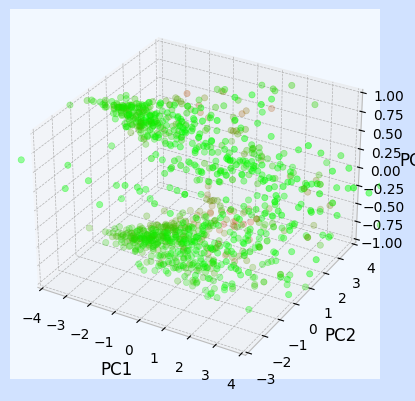

In [18]:
def theta_pca_score(df):
    key = "Theta"
    if key == "Theta":
        key = "State"
        theta = True
    else: 
        theta = False
        
    vals = torch.tensor(getattr(df, key).dropna().values.tolist())
    numVals = vals.shape[0]
    if theta:
        thetas = []
        for i in range(numVals):
            
            
            state = game.stack_var(vals[i,:])
            # print(state)
            th = game.flatten_var(game.techToParams(state)).numpy()
            thetas.append(th)            
            # thetas.append(th)
            allVals = thetas
    else:

        valsA, valsB = (vals[:,:game.N_Technologies]).numpy(), (vals[:,game.N_Technologies:]).numpy()
        allVals = np.concatenate((valsA,valsB),1)
        
    
    pca = sklearn.decomposition.PCA(3)
    pca_fit = pca.fit_transform(allVals)
    print(len(allVals))
    
    
    scores = df["Reward"].tolist()
    hi = max(scores)
    lo = min(scores)
    # print(hi, lo)
    green = np.array([0, 255, 0, 0.6*255])/255
    red =  np.array([255, 0, 0, 0.6*255])/255
    standardizedScores = [(s-lo)/(hi-lo) for s in scores]
    # print(standardizedScores)
    colors = [green * ss + red * ( 1 - ss) for ss in standardizedScores ]
    # print(colors)
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    # fig.set
    
    
    
    ax.scatter(pca_fit[:,0], pca_fit[:,1], pca_fit[:,2], color = colors)

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    
    ax.set_xlim3d((-4,4))
    ax.set_ylim3d((-3,4))
    ax.set_zlim3d((-1,1))
    
    print(lo,hi)
    print(np.array(allVals)[:10,:8])
    
    
theta_pca_score(df.loc[1:,:])

In [19]:
df.shape

(1050, 6)

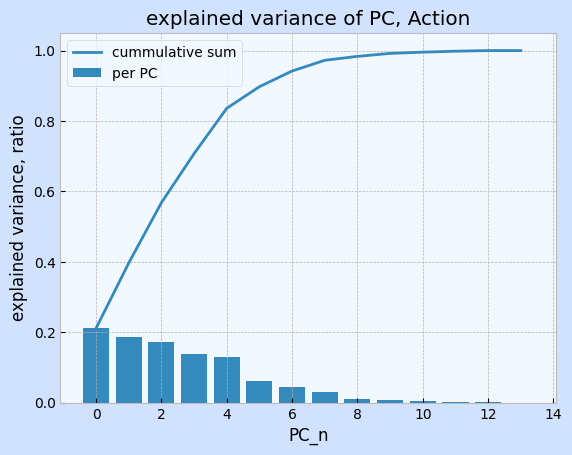

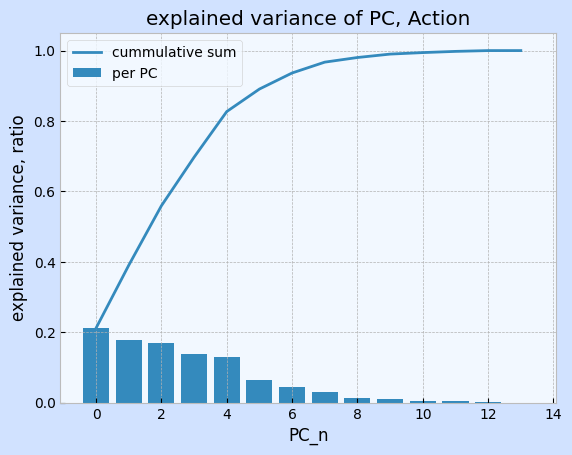

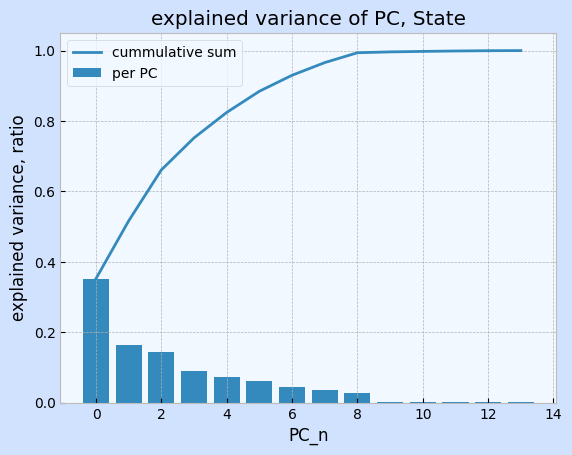

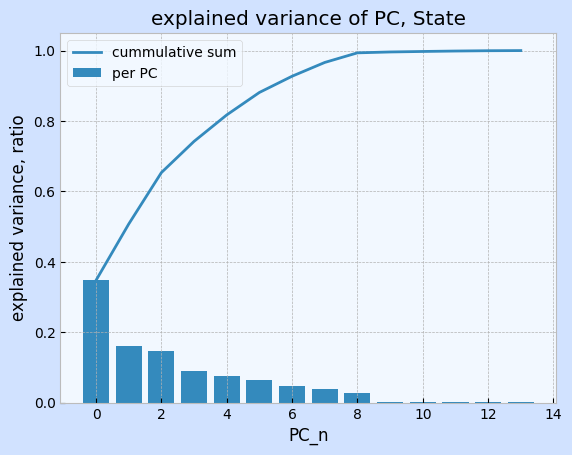

In [20]:
def all_pca_plot(df, key, t_max=False):
    if t_max:
        df = df[df.Time == df.Time.max()]
    vals = torch.tensor(getattr(df, key).dropna().values.tolist())
    
    # print(vals)
    numVals = vals.shape[0]
    valsA, valsB = (vals[:,:game.N_Technologies]).numpy(), (vals[:,game.N_Technologies:]).numpy()

    # print(valsA, valsB)
    pca = sklearn.decomposition.PCA()
    pca_fit_AB = pca.fit_transform(np.concatenate((valsA,valsB),0))
    
    evr = pca.explained_variance_ratio_
    
    fig, ax = plt.subplots(1,1)
    ax.set_title(f"explained variance of PC, {key}")
    ax.bar(range(pca.n_components_),evr, label="per PC")
    ax.plot(range(pca.n_components_),np.cumsum(evr), label ="cummulative sum")
    
    ax.set_xlabel("PC_n")
    ax.set_ylabel("explained variance, ratio")
    ax.legend(loc="best")    
all_pca_plot(df, "Action", False)
all_pca_plot(df, "Action", True)
all_pca_plot(df, "State", False)
all_pca_plot(df, "State", True)
# all_pca_plot(df, "Theta", False)
# all_pca_plot(df, "Theta", True)

C:\Users\IsakG\AppData\Local\Temp\ipykernel_31936\2262667053.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


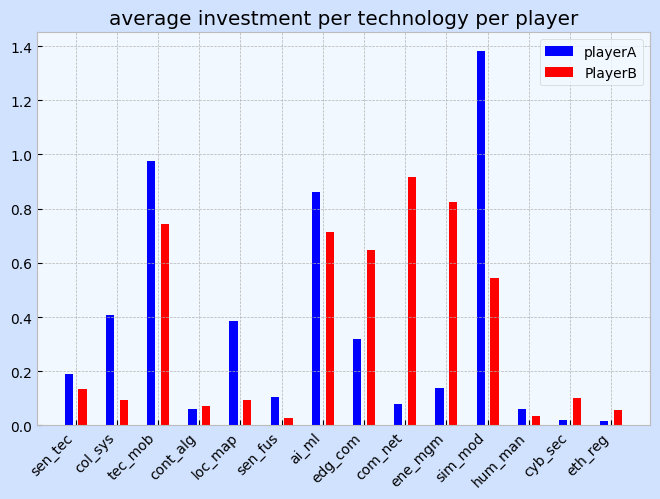

In [21]:
## Total capital invested normalised
Budget = [5,5]
nTech
actions = torch.tensor(df.Action[1:].values.tolist())
actionsA = actions[:,:nTech]
actionsB = actions[:,nTech:]

meansA = actionsA.mean(dim=0)
meansB = actionsB.mean(dim=0)

fig, ax = plt.subplots(1,1)
# ax2 = fig.add_subplot(1,2,2 )
ax.set_title(f"average investment per technology per player")


width = .5
r = np.arange(nTech)

ax.bar(r - width/3, meansA, color="blue", width=1/5, label="playerA")
ax.bar(r + width/3, meansB, color="red", width=1/5, label="PlayerB")
ax.set_xticks(r, game.TechnologyNames, rotation = 45, ha="right")
ax.legend()
# ax.bar(r + width, components[2], color="green", width=1/5, label="PC3")
# if  theta:
#     ax2.set_xticks(r + width/2, game.ParamNames * 2, rotation = 45, ha="right")
# else:
#     ax2.set_xticks(r + width/2, game.TechnologyNames * 2, rotation = 45, ha="right")
# ax2.set_xticklabels(labels = game.TechnologyNames)
# ax2.set_x
# ax2.legend()


fig.tight_layout(h_pad = 0, pad=0)
fig.show()

[432, 713, 599, 553, 678, 15, 95]
[583, 577, 527, 488, 3, 0]
[962, 947, 845, 584, 2, 0]
[813, 808, 770, 585, 2, 0]
[747, 734, 716, 586, 2, 0]
[917, 896, 847, 584, 2, 0]
[35, 16, 14, 9, 4, 0]
[134, 115, 10, 9, 4, 0]


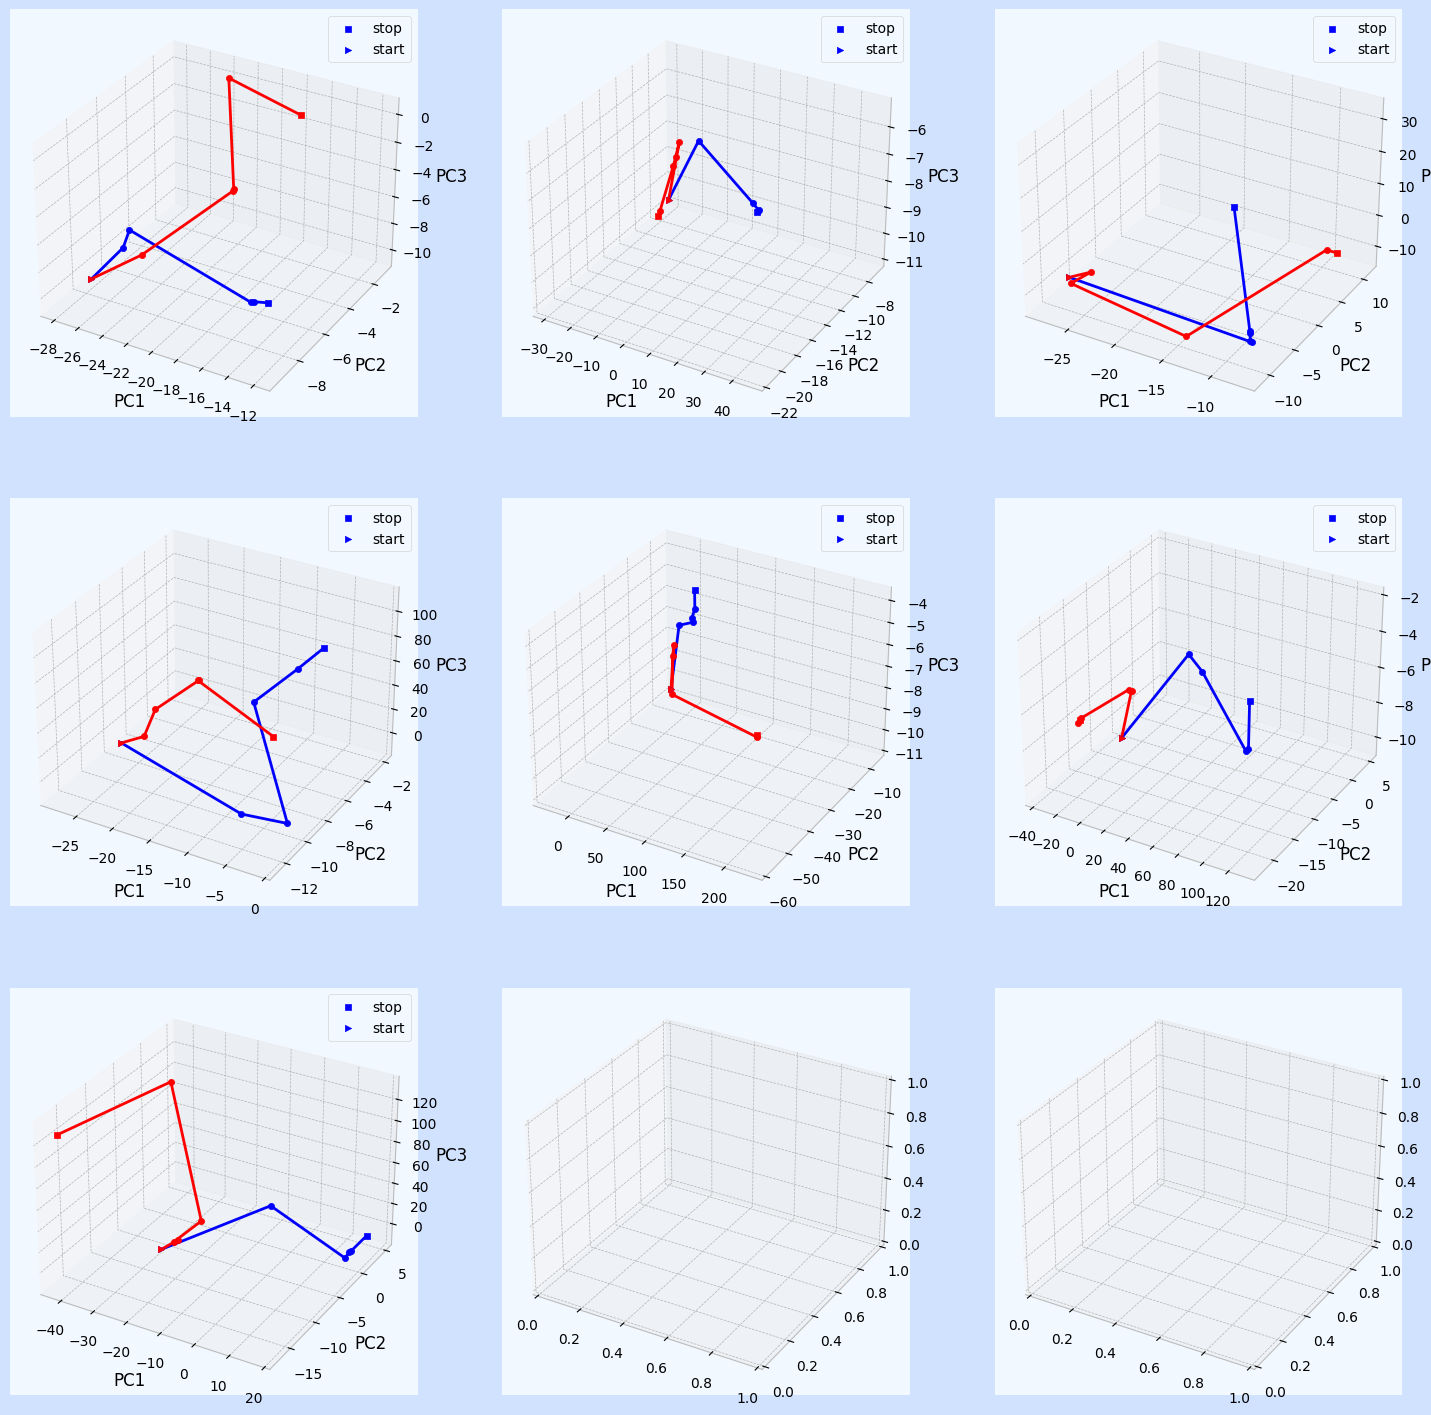

In [22]:
trajectories = []
pca = sklearn.decomposition.PCA(3)
vals = torch.tensor(getattr(df, "State").dropna().values.tolist())
valsA, valsB = (vals[:,:game.N_Technologies]).numpy(), (vals[:,game.N_Technologies:]).numpy()
allVals = np.concatenate((valsA,valsB),0)
# print(allVals.shape)
pca.fit(allVals)
states_A_pca = pca.transform(valsA)
states_B_pca = pca.transform(valsB)

# pca_fit = pca.fit_transform(allVals)

def get_trajectory(df, node_id):
    node_ids = [node_id]

    while node_id  != 0:
        node_id = int(df[df.Node_id == node_id].Parent_id.values[0])
        node_ids.append(node_id)
    # node_ids.append(0)
    return node_ids

leaf_nodes = df[df.Time == df.Time.max()].Node_id.values.tolist()
leaf_nodes
trajectories = []
for l_id in leaf_nodes:
    traj =  get_trajectory(df, node_id=l_id)
    # print(traj)
    trajectories.append(traj)
    
states = torch.Tensor(df[df.Node_id.isin(traj)].State.values.tolist())
# print(states.shape)
# statesA = states[:,:nTech].numpy()
# statesB = states[:,nTech:].numpy()
# statesA = pca.transform(statesA).tolist()
# statesB = pca.transform(statesB).tolist()

numPlots = 7
fig, axs = plt.subplots(3,3,figsize=(18,18), subplot_kw= {"projection" : "3d"})


sample_idx = random.sample(range(len(trajectories)),numPlots)
print(sample_idx)
for i, idx in enumerate(sample_idx):
    traj = trajectories[idx]
    
    ax = axs[i // 3][i % 3] # iterating over grid
    ax.set
    """det är här det fakkar"""
    # ax = fig.add_subplot(1,numPlots,i+1,projection="3d")
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    
    # ax.set_xlim3d((-25,25))
    # ax.set_ylim3d((-100,100))
    # ax.set_zlim3d((-50,50))    
    
    print(traj)
    states_A_pca_traj = states_A_pca[traj]
    states_B_pca_traj = states_B_pca[traj]
    # print(states_B_pca_traj)
    # print(states_A_pca_traj)
    # print(states_A_pca_traj[:,0])
    l = len(states_A_pca_traj)
    # print(l)
    markers = tuple(['s'] + ['o']*(l-2) + ['>'])
    ax.plot(states_A_pca_traj[:,0], states_A_pca_traj[:,1], states_A_pca_traj[:,2], color="blue")#, marker=markers)
    ax.plot(states_B_pca_traj[:,0], states_B_pca_traj[:,1], states_B_pca_traj[:,2], color="red")#, marker=markers)
    
    for j in range(len(traj)):
        if j == 0:
            label = "stop"
        elif j == (len(traj) - 1):
            label ="start"
        else:
            label = None
            
        ax.scatter(states_A_pca_traj[j,0], states_A_pca_traj[j,1], states_A_pca_traj[j,2], color="blue", marker=markers[j], label=label)
        ax.scatter(states_B_pca_traj[j,0], states_B_pca_traj[j,1], states_B_pca_traj[j,2], color="red", marker=markers[j])#, label=label)
        ax.legend()
    # ax.show()


In [23]:
# import math
# def my_normal_draw(mu,sigma):
#     return np.random.normal(mu,sigma)

# def standard_norm(mu)
# def my_log_normal_draw(mu,sigma):
    
#     return math.exp(math.log(mu) + sigma*my_normal_draw(0, 1))

# print(my_log_normal_draw(1.05,1.3))

In [24]:
# import os, pickle
# tempDirPath = "temporarySaveDir"   

# Qpath = os.path.join(tempDirPath, "Q.pkl")
# with open(Qpath,"rb") as f:
#     Q = pickle.load(f)


# histpath = os.path.join(tempDirPath, "hist.pkl")
# with open(histpath,"rb") as f:
#     History = pickle.load(f)
    
# Q
# History

In [25]:


S


NameError: name 'S' is not defined